# Pointwise R. - CONFINE
## RF

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.neighbors import NearestNeighbors

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df_pollu = df.copy()
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()
df_final = df_final.dropna()

In [4]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)


df_train = df_final[train_mask]
df_val = df_final[val_mask]


print(f"Training set size: {df_train.count()} rows")
print(f"Validation set size: {df_val.count()} rows")
print(f"Training set date range: {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"Validation set date range: {df_val['Date'].min()} to {df_val['Date'].max()}")

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

Training set size: Date            1461
DayOfWeekNum    1461
WeekOfYear      1461
Month           1461
IsWeekend       1461
IsHoliday       1461
NUMBER_INT      1461
temp_max        1461
temp_min        1461
humidity_max    1461
dtype: int64 rows
Validation set size: Date            360
DayOfWeekNum    360
WeekOfYear      360
Month           360
IsWeekend       360
IsHoliday       360
NUMBER_INT      360
temp_max        360
temp_min        360
humidity_max    360
dtype: int64 rows
Training set date range: 2015-01-01 00:00:00 to 2018-12-31 00:00:00
Validation set date range: 2019-01-01 00:00:00 to 2019-12-26 00:00:00


In [5]:
X_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,temp_max,temp_min,humidity_max
0,3,1,1,0,1,33.9,20.6,89.0
1,4,1,1,0,0,32.9,21.0,87.0
2,5,1,1,1,0,33.5,20.2,83.0
3,6,1,1,1,0,30.6,22.2,81.0
4,0,2,1,0,0,30.8,20.8,79.0


In [6]:
X_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,temp_max,temp_min,humidity_max
1461,1,1,1,0,1,27.9,19.2,92.0
1462,2,1,1,0,0,31.1,18.9,90.0
1463,3,1,1,0,0,30.7,20.4,88.0
1464,4,1,1,0,0,25.4,19.0,91.0
1465,5,1,1,1,0,30.1,18.6,91.0


In [7]:
y_val.head()

1461    44
1462    45
1463    28
1464    37
1465    36
Name: NUMBER_INT, dtype: int64

In [8]:
results = []

In [9]:

best_rf_model_base = RandomForestRegressor(
    n_estimators=20,
    max_depth=6,
    min_samples_split=16,
    random_state=9
)

best_rf_model_base.fit(X_train, y_train)

y_pred = best_rf_model_base.predict(X_val)

# Metrics 1y
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
mape_val = mape(y_val, y_pred)
smape_val = smape(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

results.append({
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'sMAPE': smape_val,
    'R2': r2,
    'Correlation': corr
})

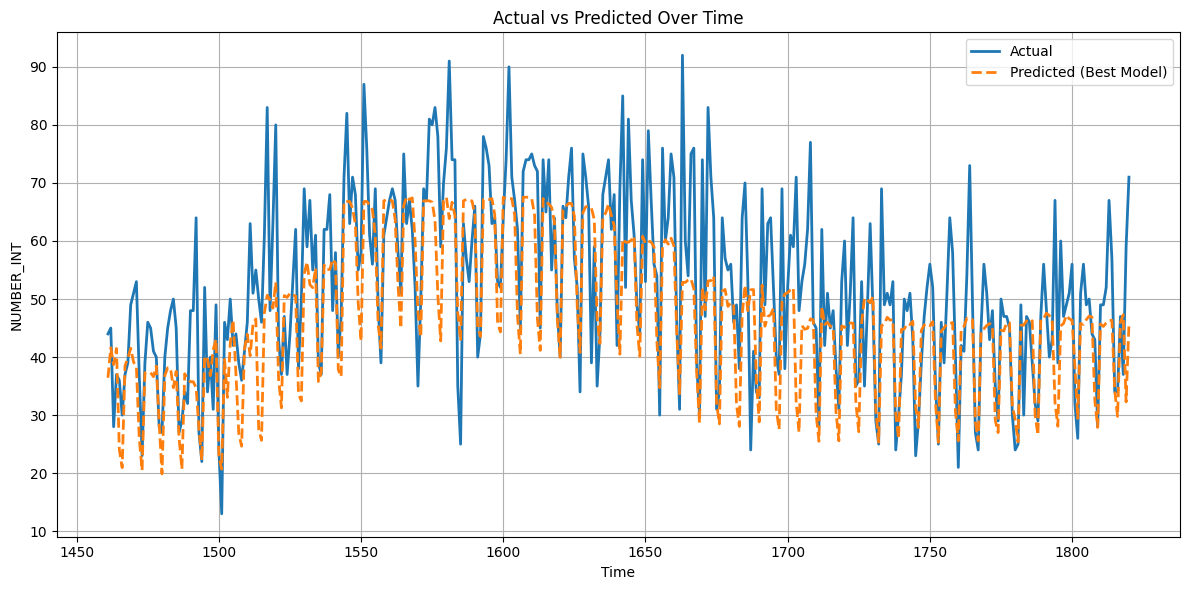

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

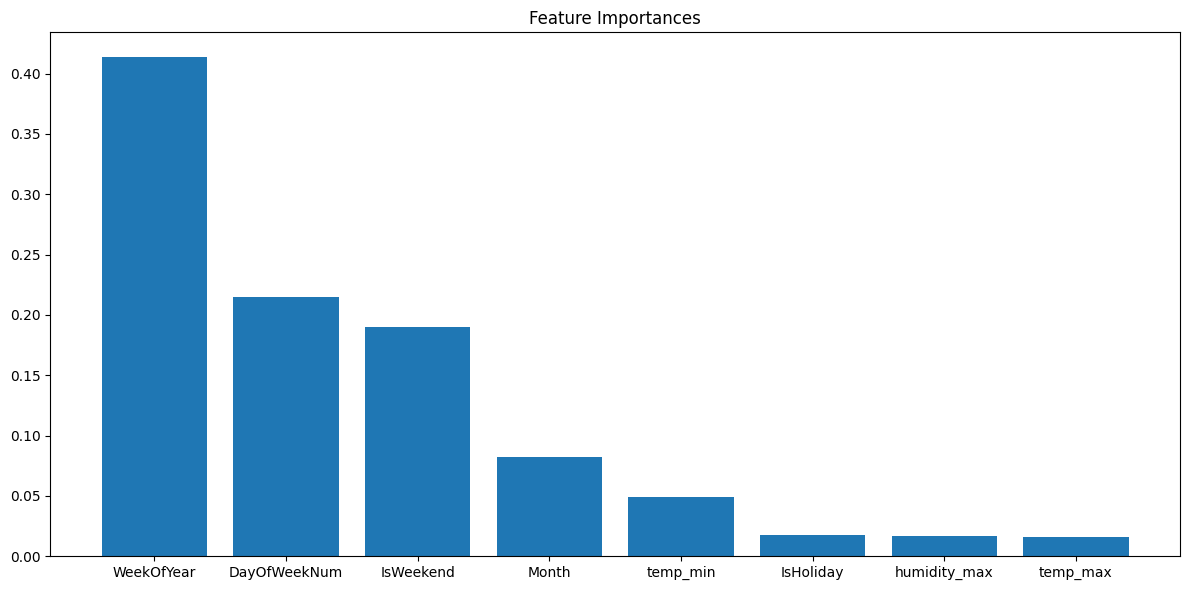

In [11]:
importances = best_rf_model_base.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices])
plt.tight_layout()
plt.show()

In [12]:
importances[indices]

array([0.41355776, 0.21510835, 0.19030288, 0.08203985, 0.04886889,
       0.01772122, 0.01689043, 0.01551062])

# CONFINE

In [13]:
# Scaler

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

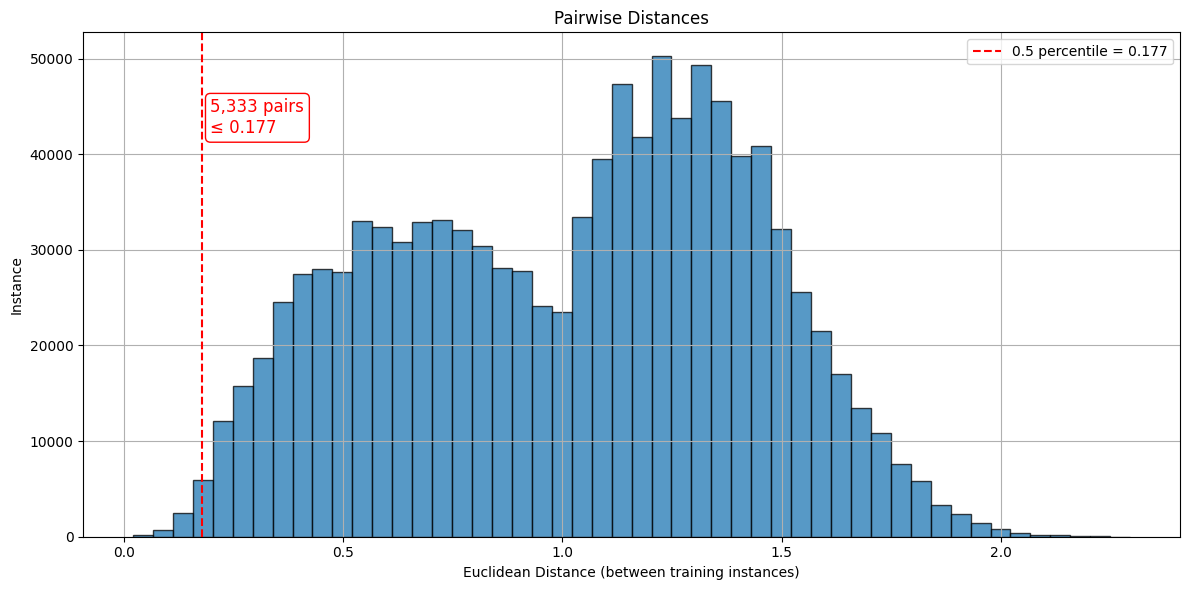

In [14]:
# Pairwise distances in training set
train_distance_matrix = euclidean_distances(X_train_scaled)
i_upper = np.triu_indices_from(train_distance_matrix, k=1)
pairwise_distances_train = train_distance_matrix[i_upper]

# TODO: select percentile (5th)
percentile_number = 0.5

selected_percentile = np.percentile(pairwise_distances_train, percentile_number)

count_below_percentile = np.sum(pairwise_distances_train <= selected_percentile)

plt.figure(figsize=(12, 6))
plt.hist(pairwise_distances_train, bins=50, edgecolor='black', alpha=0.75)
plt.axvline(selected_percentile, color='red', linestyle='--', label=f'{percentile_number} percentile = {selected_percentile:.3f}')
plt.text(selected_percentile + 0.02, plt.ylim()[1]*0.8,
         f'{count_below_percentile:,} pairs\n≤ {selected_percentile:.3f}',
         color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

plt.xlabel("Euclidean Distance (between training instances)")
plt.ylabel("Instance")
plt.title("Pairwise Distances")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
within_threshold = (train_distance_matrix <= selected_percentile)

np.fill_diagonal(within_threshold, False)

# Count neighbors within threshold for each instance
neighbors_within_threshold = np.sum(within_threshold, axis=1)

k_max = int(np.mean(neighbors_within_threshold))
k_max

7

## Setup

In [16]:
final_min_cluster_uni = 7

In [17]:
class ConfineScorer:
    """
    k-NN CONFINE reliability scorer
    y_true / y_pred for current instance and neighbours.
    """

    def __init__(
        self,
        model,
        X_train_scaled,
        X_train_original,
        y_train,
        k: int = 14,
    ):
        self.k = k
        self.model = model # keep for later per-row predict()
        self.Xts  = np.asarray(X_train_scaled)

        # original-scale training features -> DataFrame (for nice printing)
        self.Xto = (
            X_train_original
            if isinstance(X_train_original, pd.DataFrame)
            else pd.DataFrame(
                np.asarray(X_train_original),
                columns=[f"f{i}" for i in range(np.asarray(X_train_original).shape[1])],
            )
        )


        # true & predicted on the training set
        self.y_train      = np.asarray(y_train)
        self.y_hat_train  = model.predict(X_train_original)
        self.sq_err_train = np.square(self.y_train - self.y_hat_train)

        # IQR-based trimming of squared errors ─────────────────────────
        q1, q3 = np.percentile(self.sq_err_train, [25, 75])
        iqr          = q3 - q1
        self.err_fence = q3 + 1.5 * iqr            # upper fence

        trimmed_err = self.sq_err_train[self.sq_err_train <= self.err_fence]

        # fit MinMaxScaler on *trimmed* error distribution
        self.err_scaler = MinMaxScaler((0, 1)).fit(trimmed_err.reshape(-1, 1))

        # neighbour index
        self.nn = NearestNeighbors(n_neighbors=k).fit(self.Xts)


    # ------------------------------------------------------------------ Helpers
    def print_error_stats(self) -> None:
            """Print overall MSE and RMSE on the training set."""
            mse  = self.sq_err_train.mean()
            rmse = np.sqrt(mse)
            print(f"Training-set MSE : {mse:,.4f}")
            print(f"Training-set RMSE: {rmse:,.4f}")

    def get_error_array(self, print_array: bool = False) -> np.ndarray:
        """
        Return the per-row squared errors.  Set print_array=True to print them.
        """
        if print_array:
            print(self.sq_err_train)
        return self.sq_err_train.copy()

    # ------------------------------------------------------------------
    def score(
        self,
        x_scaled,
        x_original=None,
        y_true_current=None,      # ground-truth
        verbose: bool = False,
    ):
        """
        Parameters
        ----------
        x_scaled: 1-D array/Series or (1, n_features) - scaled row
        x_original: same row in original units (for printing)
        y_true_current: float or int, optional - target value of this row
        verbose: if True, prints diagnostics & returns details

        Returns
        -------
        float  (or (score, details_dict) if verbose=True)
        """

        # ensure (1, n_features)
        x_arr = np.asarray(x_scaled)
        if x_arr.ndim == 1:
            x_arr = x_arr.reshape(1, -1)

        # k nearest neighbours (training indices)
        _, idx = self.nn.kneighbors(x_arr, n_neighbors=self.k)
        nbr_idx = idx[0]

        # local error
        local_mse   = self.sq_err_train[nbr_idx].mean()
        # scaled_mse  = self.err_scaler.transform([[local_mse]])[0, 0]


        local_clip = min(local_mse, self.err_fence)          # cap to fence
        scaled_mse = self.err_scaler.transform([[local_clip]])[0, 0]


        # TODO: use scalled MSE for the final score?
        conf_score = 1.0 - scaled_mse
        # conf_score  = 1.0 - local_mse

        if not verbose:
            return conf_score

        # ---------- gather diagnostics ----------
        # current instance features (original scale if provided)
        current_orig = (
            np.asarray(x_original).reshape(1, -1) if x_original is not None else x_arr
        )
        current_df = pd.DataFrame(current_orig, columns=self.Xto.columns)

        # current prediction
        # y_pred_current = self.model.predict(x_arr)[0]
        if x_original is not None:
           y_pred_current = self.model.predict(
               np.asarray(x_original).reshape(1, -1)
           )[0]
        else:
           # Fallback: assume the model *was* trained on scaled features.
           print("Error: x_original is None")
           y_pred_current = 999999999999999999999

        # neighbour features & residuals
        neigh_df   = self.Xto.iloc[nbr_idx].reset_index(drop=True)
        neigh_true = self.y_train[nbr_idx]
        neigh_pred = self.y_hat_train[nbr_idx]
        neigh_abs  = np.abs(neigh_true - neigh_pred)

        # ------------- printing -------------
        print("\nCONFINE diagnostics")
        print(f"CONFINE score : {conf_score:.4f}")
        print(f"Local MSE     : {local_mse:,.4f}  (scaled {scaled_mse:.4f})\n")

        print("Current instance features:")
        print(current_df.to_string(index=False))

        print("\nCurrent instance target / prediction:")
        print(f"y_true : {y_true_current}" if y_true_current is not None else "y_true :  —")
        print(f"y_pred : {y_pred_current}\n")

        print("Neighbour feature rows:")
        print(neigh_df.to_string(index=False))

        print("\nNeighbour targets / predictions / |error|:")
        neigh_table = pd.DataFrame({
            "y_true": neigh_true,
            "y_pred": neigh_pred,
            "|y-ŷ|":  neigh_abs,
        })
        print(neigh_table.to_string(index=False))
        print("-" * 60)

        # details object
        details = {
            "neigh_indices": nbr_idx,
            "current_features": current_df,
            "neighbour_features": neigh_df,
            "current_y_true": y_true_current,
            "current_y_pred": y_pred_current,
            "neigh_y_true": neigh_true,
            "neigh_y_pred": neigh_pred,
            "neigh_abs_error": neigh_abs,
            "local_mse": local_mse,
            "scaled_mse": scaled_mse,
            "confine_score": conf_score,
        }
        return conf_score, details


In [18]:
confine = ConfineScorer(
    model = best_rf_model_base,
    X_train_scaled = X_train_scaled,
    X_train_original = X_train,
    y_train = y_train,
    k = final_min_cluster_uni,
)

# verbose printout – shows *all* feature columns
print (f"True Value: {y_val.iloc[1]:.4f}")

score, info = confine.score(
    x_scaled   = X_val_scaled.iloc[1],
    x_original = X_val.iloc[1],
    verbose    = True,
)

True Value: 45.0000

CONFINE diagnostics
CONFINE score : 0.8852
Local MSE     : 23.9138  (scaled 0.1148)

Current instance features:
 DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max
          2.0         1.0    1.0        0.0        0.0      31.1      18.9          90.0

Current instance target / prediction:
y_true :  —
y_pred : 41.60728878263213

Neighbour feature rows:
 DayOfWeekNum  WeekOfYear  Month  IsWeekend  IsHoliday  temp_max  temp_min  humidity_max
            2           1      1          0          0      30.1      18.7          93.0
            2           2      1          0          0      32.7      19.4          92.0
            2           4      1          0          0      30.4      20.8          89.0
            2           5      1          0          0      30.0      17.4          94.0
            1           3      1          0          0      30.7      19.1          90.0
            2           3      1          0         

/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [19]:
confine.print_error_stats()

Training-set MSE : 69.0145
Training-set RMSE: 8.3075


In [20]:
# quiet scoring loop
scores = np.array([confine.score(row) for row in X_val_scaled.values])

In [21]:
scores

array([ 0.44224956,  0.88521364,  0.80744788,  0.95299209,  0.90842559,
        0.88164051,  0.57493483,  0.83275414,  0.81202997,  0.79252271,
        0.8609748 ,  0.87950473,  0.89826089,  0.75182759,  0.78995149,
        0.84583585,  0.68301111,  0.79746621,  0.74460206,  0.93134366,
        0.90057149,  0.78462112,  0.83960987,  0.84756692,  0.85352532,
        0.92753367,  0.9435668 ,  0.86264239,  0.88850506,  0.9027081 ,
        0.78083163,  0.92283243,  0.74384088,  0.83384966,  0.65292058,
        0.8077947 ,  0.72346568,  0.6963538 ,  0.85368482,  0.86259558,
        0.94318097,  0.67128087,  0.29539575,  0.37901855,  0.49523328,
        0.91324821,  0.87740108,  0.75221632,  0.57469801,  0.69629852,
        0.51374119,  0.50814776,  0.82329425,  0.88615291,  0.91713561,
        0.58738306,  0.84329813,  0.27067612,  0.63809996,  0.73386698,
        0.97259707,  0.8313454 ,  0.41075633,  0.60254283,  0.68853094,
        0.85216286,  0.86499283,  0.85895965,  0.87965544,  0.52

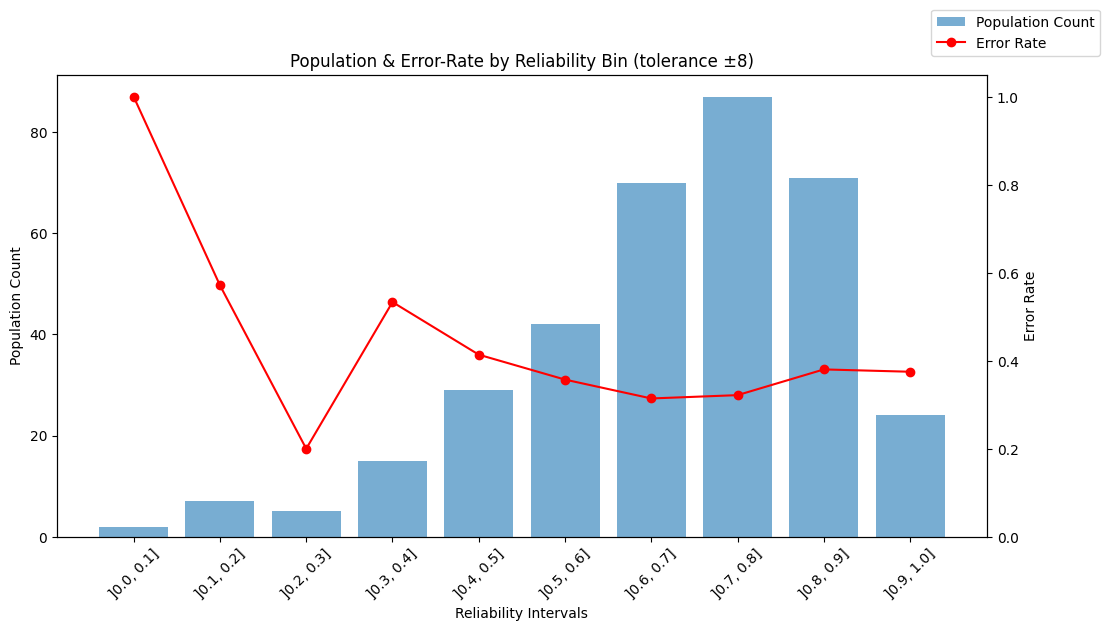

In [22]:
# ------------------------------------------------------------------
# CONFIVE reliability vs. error-rate plot
# ------------------------------------------------------------------

tolerance = 8  # TODO acceptable absolute-error band


# Assemble a DataFrame for analysis
df_plot = df_val.copy()
df_plot["y_true"] = y_val.values
df_plot["y_pred"] = y_pred
df_plot["abs_error"] = np.abs(df_plot["y_true"] - df_plot["y_pred"])
df_plot["correct"] = df_plot["abs_error"] <= tolerance
df_plot["Reliability"] = scores

bins = np.linspace(0, 1, 11) # 0.0, 0.1, ..., 1.0
labels = [f"]{bins[i]:.1f}, {bins[i+1]:.1f}]" for i in range(len(bins)-1)]
df_plot["reliability_bin"] = pd.cut(
    df_plot["Reliability"], bins=bins,
    labels=labels, include_lowest=True
)

# Aggregate
grouped = df_plot.groupby("reliability_bin", observed=True)
pop_count = grouped.size()
error_rate = 1 - grouped["correct"].sum() / pop_count

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pop_count.index, pop_count.values,
        alpha=0.6, label="Population Count")
ax1.set_ylabel("Population Count")
ax1.set_xlabel("Reliability Intervals")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(error_rate.index, error_rate.values,
         marker='o', color='red', label="Error Rate")
ax2.set_ylabel("Error Rate")
ax2.set_ylim(0, 1.05)

plt.title(f"Population & Error-Rate by Reliability Bin (tolerance ±{tolerance})")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1))

# plt.tight_layout()
plt.show()

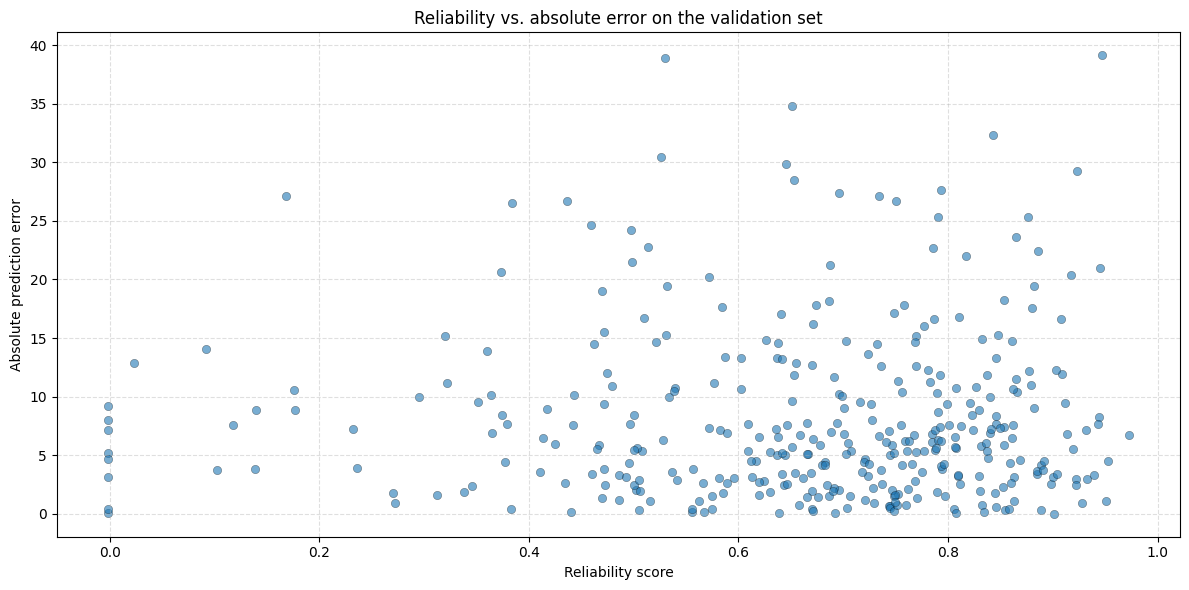

In [23]:
# ---------------------------------------------------------------
# Scatter: Reliability vs. absolute prediction error
# ---------------------------------------------------------------

errors = np.abs(y_val.values - y_pred)

df_re_err = pd.DataFrame({
    "Reliability": scores,
    "AbsError"   : errors,
})

plt.figure(figsize=(12, 6))
plt.scatter(df_re_err["Reliability"],
            df_re_err["AbsError"],
            alpha=0.6, edgecolor="k", linewidth=0.3)
plt.xlabel("Reliability score")
plt.ylabel("Absolute prediction error")
plt.title("Reliability vs. absolute error on the validation set")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
